In [7]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [8]:
base_dirs = {
    "Without": Path("data/Without EDM"),
    "With": Path("data/With EDM")
}

dfs = []

for edm_state, dir_path in base_dirs.items():
    for file in sorted(dir_path.glob("G2_*.pkl")):
        run_id = int(file.stem.split("_")[1])
        with open(file, "rb") as f:
            X, Y, Z = pickle.load(f)
        
        df = pd.DataFrame({
            "lambda": X.ravel(),
            "theta_mrad": (Y * 1000).ravel(),
            "prob_density": Z.ravel(),
            "run_id": run_id,
            "edm_state": edm_state
        })
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [12]:
output_base = Path("outputs")

for edm_state in tqdm(["With", "Without"], desc="EDM States"):
    # Match the folder names on disk
    folder_name = "With EDM" if edm_state == "With" else "Without EDM"
    output_dir = output_base / folder_name
    output_dir.mkdir(parents=True, exist_ok=True)

    for run_id in range(29):
        subset = df_all.query("edm_state == @edm_state and run_id == @run_id")
        if subset.empty:
            print(f"Skipping {edm_state} run {run_id:02} — no data found.")
            continue

        # Get unique sorted axes
        lambdas = np.sort(subset["lambda"].unique())
        thetas = np.sort(subset["theta_mrad"].unique())

        # Reshape back into 2D grid
        Z_grid = subset.pivot_table(
            index="theta_mrad",
            columns="lambda",
            values="prob_density"
        ).values

        # File name format (matches your .pkl naming)
        if edm_state == "With":
            fname = f"G2_{run_id:02}_withEDM_heatmap.png"
        else:
            fname = f"G2_{run_id:02}_heatmap.png"

        save_path = output_dir / fname

        # Plot and save (no inline output)
        plt.figure(figsize=(6,6))
        plt.imshow(
            Z_grid,
            extent=[lambdas.min(), lambdas.max(), thetas.min(), thetas.max()],
            aspect='auto',
            origin='lower',
            cmap='viridis'
        )
        plt.xlabel(r"Fractional energy ($\lambda$)")
        plt.ylabel(r"Longitudinal angle ($\theta_L$) [mrad]")
        plt.title(f"{folder_name} — Run {run_id:02}")
        plt.colorbar(label="Probability density")
        plt.tight_layout()
        plt.savefig(save_path, dpi=200)
        plt.close()

        print(f"Saved: {save_path.resolve()}")


EDM States:   0%|          | 0/2 [00:00<?, ?it/s]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_00_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_01_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_02_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_03_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_04_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_05_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_06_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Wit

EDM States:  50%|█████     | 1/2 [00:48<00:48, 48.59s/it]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_28_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_00_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_01_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_02_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_03_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_04_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_05_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_06_heatmap.png
Sav

EDM States: 100%|██████████| 2/2 [01:43<00:00, 51.86s/it]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_28_heatmap.png


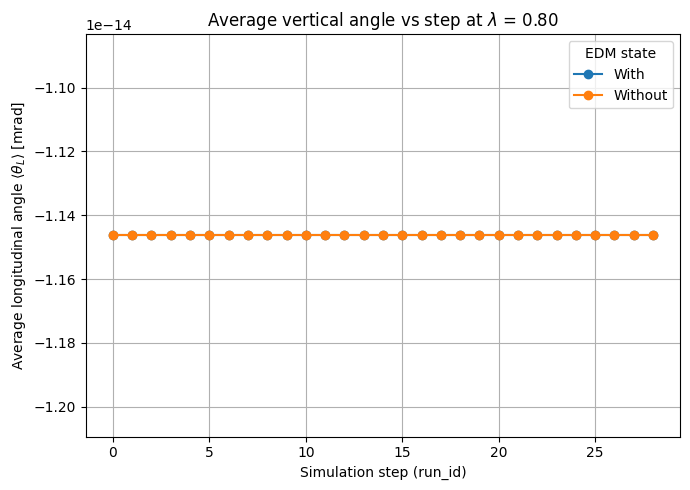

In [14]:
target_lambda = 0.8
tolerance = 0.005

# Filter DataFrame to only rows near this lambda
df_slice = df_all[np.isclose(df_all["lambda"], target_lambda, atol=tolerance)]

# Group by EDM state and run ID, and compute mean vertical angle
mean_angles = (
    df_slice.groupby(["edm_state", "run_id"])["theta_mrad"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(7,5))
for edm_state, subset in mean_angles.groupby("edm_state"):
    plt.plot(subset["run_id"], subset["theta_mrad"], marker='o', label=edm_state)

plt.xlabel("Simulation step (run_id)")
plt.ylabel(r"Average longitudinal angle $\langle \theta_L \rangle$ [mrad]")
plt.title(rf"Average vertical angle vs step at $\lambda$ = {target_lambda:.2f}")
plt.legend(title="EDM state")
plt.grid(True)
plt.tight_layout()
plt.show()
